reference:[https://github.com/rfma23/RSTDP](https://github.com/rfma23/RSTDP)

+ 输入是3*11的神经元


+ 输出是1*9的神经元


+ 卷积核是1个3*3的矩阵，对9个输出都是相同的


```python
    grid1 = np.array([[1,0,0,0,5,6,7,0,0,0,9],
                    [2,3,0,0,0,8,0,0,0,10,11],
                    [4,0,0,0,0,0,0,0,0,0,12]],
                dtype=np.float32)

    grid2 = np.array([[1,0,0,0,9,10,11,0,0,0,5],
                    [2,3,0,0,0,12,0,0,0,6,7],
                    [4,0,0,0,0,0,0,0,0,0,8]],
                dtype=np.float32)
```

> 当输入是这两种的形式时，目的是训练使用r-stdp进行区分，可以看出不同的输入上，有神经元输入的地方都是相同的，并且时间上的早期脉冲也是相同的，不同的是后期脉冲顺序/时间

> 训练的结果自然就体现在神经元的权重w上

In [265]:
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools 
import logging

In [266]:
in_spike_dtype = np.dtype([('x', np.uint8), ('y', np.uint8), ('ts', np.float32)]) # 自定义数据类型
# data = np.array([(10, 20, 3.14), (30, 40, 6.28)], dtype=in_spike_dtype)
in_spike_dtype

dtype([('x', 'u1'), ('y', 'u1'), ('ts', '<f4')])

In [267]:
out_spike_dtype = np.dtype([('grid', np.uint8), ('x', np.uint8), ('y', np.uint8), ('ts', np.float32)])
out_spike_dtype

dtype([('grid', 'u1'), ('x', 'u1'), ('y', 'u1'), ('ts', '<f4')])

In [268]:
class Grid:
    def __init__(self, xsize, ysize, grid):
        self.xsize = xsize
        self.ysize = ysize
        self.grid = grid
        
    @classmethod
    def get_grid(cls, i):
        """
            类似于一个构造函数
        """
        if i == 'zero' :
            grid = np.array([[0,0,0,0,0,0,0,0,0,0,0],
                             [0,0,0,0,0,0,0,0,0,0,0],
                             [0,0,0,0,0,0,0,0,0,0,0]],
                           dtype=np.float32)
        elif i == 0 :
            grid = np.array([[1,0,0,0,5,6,7,0,0,0,9],
                             [2,3,0,0,0,8,0,0,0,10,11],
                             [4,0,0,0,0,0,0,0,0,0,12]],
                           dtype=np.float32)
            
        elif i == 1 :
            grid = np.array([[1,0,0,0,9,10,11,0,0,0,5],
                             [2,3,0,0,0,12,0,0,0,6,7],
                             [4,0,0,0,0,0,0,0,0,0,8]],
                           dtype=np.float32)
            
        return cls(3, 11, grid)
    
    def show(self):
        """
            使用灰度图显示3*12矩阵
        """
        grayscale = (self.grid > 0).astype(int)
        for (i, j), value in np.ndenumerate(self.grid): 
            if value > 0 : plt.text(y=i,x=j,s=int(value)) # 这里让np中的j当作x轴
        plt.imshow(grayscale, vmin=-1, vmax =1, cmap='gray')
        plt.xticks(range(self.grid.shape[1]), rotation=0)
        plt.show()
    
    @property
    def spikes(self):
        """
            Retrieves the grid spikes in a recarray format with
            spikes sorted by timestamp
        """
        grid_spikes = []
        for (i, j), value in np.ndenumerate(self.grid):
             if value > 0 : grid_spikes.append((i, j, value))
        np_spikes = np.array(grid_spikes, dtype=in_spike_dtype)
        np_spikes.sort(order='ts') # 按照自定义类型的ts-也就是发放时间排序
        return np_spikes
    
    @property
    def shape(self):
        return self.grid.shape
    
    def __str__(self):
        # return self.spikes
        return "{0}".format(self.spikes)
    
    def __repr__(self):
        return self.__str__()

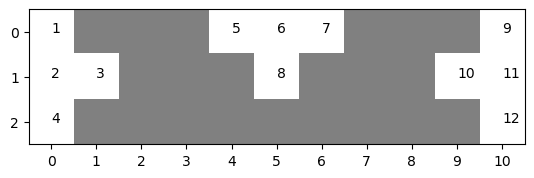

In [269]:
A = Grid.get_grid(i=0)
A.show()

In [270]:
A.spikes

array([(0,  0,  1.), (1,  0,  2.), (1,  1,  3.), (2,  0,  4.),
       (0,  4,  5.), (0,  5,  6.), (0,  6,  7.), (1,  5,  8.),
       (0, 10,  9.), (1,  9, 10.), (1, 10, 11.), (2, 10, 12.)],
      dtype=[('x', 'u1'), ('y', 'u1'), ('ts', '<f4')])

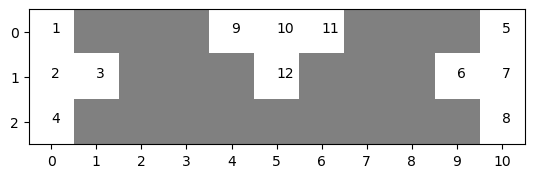

In [271]:
B = Grid.get_grid(i=1)
B.show()

In [272]:
B.spikes 

array([(0,  0,  1.), (1,  0,  2.), (1,  1,  3.), (2,  0,  4.),
       (0, 10,  5.), (1,  9,  6.), (1, 10,  7.), (2, 10,  8.),
       (0,  4,  9.), (0,  5, 10.), (0,  6, 11.), (1,  5, 12.)],
      dtype=[('x', 'u1'), ('y', 'u1'), ('ts', '<f4')])

<div align="center">
    <img src='images/rstdp1.png' width=400>
</div>

其实也就是代表，对于一个输出的3*3的对应的9个输入中，只要有一个来了脉冲，膜电压就会更新一次，并且可以发现，这里没leak-泄露，也就是没有衰减项

In [273]:
class NeuronalGrids:
    def __init__(self, in_grid_shape, neuron_rf=3, n_grids=2, n_classes=2) -> None:
        """
            in_grid_shape : 输入层shape, 比如我这里是 3 * 11
            neuron_rf ：卷积边长（默认长宽相等）
            n_grids = 2 ： 是 n_classes 的 k 倍， 还是一种分类的感觉, 这里暂取他们相等
            n_classes ： 要分多少类
        """
        self.in_grid_shape = in_grid_shape
        self.out_grid_shape = ((in_grid_shape[0] - neuron_rf + 1),
                               (in_grid_shape[1] - neuron_rf + 1)) # 1*9
        
        # assert self.out_grid_shape == (1,9), "self.out_grid_shape error!"
        
        self.n_classes = n_classes

        self.n_grids = n_grids # 卷积核的个数

        self.neuron_rf = neuron_rf

        self.synaptic_weights = np.random.normal(0.8, 0.05, (self.n_grids, self.neuron_rf, self.neuron_rf)) # 权重初始化

        self.neuron_potential = np.zeros((n_grids, *self.out_grid_shape), dtype=np.float32) # 膜电压初始化为0

        self.neuron_threshold = 3.2 # 超参数

        self.ar_plus = 0.075 # 超参数
        self.ar_neg = -0.05 # 超参数
        self.ap_plus = 0.04 # 超参数
        self.ap_neg = -0.1 # 超参数

        self.small_qty = 0.005 # [small_qty, 1-small_qty] # 超参数

        self.reset_metric() # 初始化参数
    
        self.sensitive_neurons_to_pos = self.get_sensitive_neurons() # 对于每一个输入神经元，能影响的输出神经元是有限的，提前计算出来

        # print(self.sensitive_neurons_to_pos)

        self.dropouts = [] # 不懂


    def get_sensitive_neurons(self):
        """ 
            找到每个输入位置会影响的输出位置：
            比如：
            输入位置的（1，3）会影响输出位置的（0，1） （0，2） （0，3）
        """
        sensitive_neurons_to_pos = {}

        for x, y in itertools.product(range(self.in_grid_shape[0]), range(self.in_grid_shape[1])): # 两层循环 输入维度
            sensitive_neurons_to_pos[(x,y)] = []

        for row, col in itertools.product(range(self.out_grid_shape[0]), range(self.out_grid_shape[1])): # 输出维度
            neuron_center_row = row + self.neuron_rf//2 # 1
            neuron_center_col = col + self.neuron_rf//2 # 先求输出该行在输入中的 w 的中心位置
            
            # relevant area for the neuron
            row_lb = neuron_center_row-self.neuron_rf//2 # 0
            row_ub = neuron_center_row+self.neuron_rf//2 # 2
            col_lb = neuron_center_col-self.neuron_rf//2 # 
            col_ub = neuron_center_col+self.neuron_rf//2
            
            if self.neuron_rf % 2 != 0:
                for x, y in itertools.product(range(row_lb, row_ub+1), range(col_lb, col_ub+1)):
                    sensitive_neurons_to_pos[(x,y)].append((row, col))
            else:
                for x, y in itertools.product(range(row_lb, row_ub), range(col_lb, col_ub)):
                    sensitive_neurons_to_pos[(x,y)].append((row, col))
                
        return sensitive_neurons_to_pos


    def reset_metric(self):
        # 这里的引入，在论文中是为了，调整训练的收敛和过拟合问题
        self.n_silence = 0 # 输出层没有脉冲的数量
        self.n_hit = 0 # 分类正确的
        self.n_miss = 0 # 分类错误的
        self.n_samples = 0 # 总采样数



    def get_temporal_winner(self, spikes, dropout=0.2, neuron_dropout=0.1):
        """ 
            找到第一个脉冲的输出神经元，这里是论文中的一个观点，只对输出层发放脉冲的第一个神经元有关的连接权重进行更新，与统计频率相比很大的简化了计算
        """
        neuron_potential = np.zeros((self.n_grids, *self.out_grid_shape), dtype=np.float32) # 这里每次都是从零开始的!

        hasFired = False

        is_active = np.random.random(self.n_grids) # 

        is_active_neuron = np.random.random(self.out_grid_shape) # 有引入两层dropout

        for spike in spikes: # 遍历所有脉冲输入
            
            for grid in range(self.n_grids): # 对不同的输出层, 这里的顺序不会有问题吗， 先遍历哪一层？

                if is_active[grid] > dropout: # 这里引入随机丢弃

                    if not hasFired:
                        
                        affected_neurons = self.sensitive_neurons_to_pos[(spike['x'], spike['y'])] # spike 应该是一个元组坐标, 这里感觉应该从字典里拿不出来吧

                        for affected_neuron in affected_neurons: # 遍历收到影响的输出神经元
                            
                            if is_active_neuron[affected_neuron] > neuron_dropout: # 引入第二层随机度

                                neuron_row, neuron_col = affected_neuron # 得到坐标

                                relative_x, relative_y = self.relative_position(spike, affected_neuron) # 从输入脉冲，和输出神经元位置 定位到 需要计算的权重w的坐标

                                neuron_potential[grid, neuron_row, neuron_col] += self.synaptic_weights[grid, relative_x, relative_y] # 计算膜电位

                                if neuron_potential[grid, neuron_row, neuron_col] > self.neuron_threshold: # 
                                    
                                    out_spike = np.array([(grid, neuron_row, neuron_col, spike['ts'])], dtype=out_spike_dtype) 
                                    
                                    hasFired = True # 这里如果触发了，后面的那个grid就执行不了了，按理说应该都跑出来

                                    break
                    else:
                        return out_spike[0]
        
        return None
        


    def predict(self, spikes):
        """
            输出预测结果
        """
        pred_class = None

        winner_spike = self.get_temporal_winner(spikes, dropout=0, neuron_dropout=0)

        if winner_spike is not None:
            
            pred_class = winner_spike['grid'] 
        
        return pred_class
    

    def process(self, spikes, label, train=True):
        # 训练过程
        dropout = 0.4 * (1 - self.n_hit / (self.n_samples + 1)) # 命中率越低，drop越多 系数是超参数
        neuron_dropout = 0.2 * (1 - self.n_hit / (self.n_samples + 1)) # 命中率越低，drop越多 系数是超参数

        self.dropouts.append((dropout, neuron_dropout))

        winner_spike = self.get_temporal_winner(spikes, dropout, neuron_dropout) # 获取 最先发放的脉冲

        # logging.info(winner_spike)
        reward = False
        pred_class = None

        if winner_spike is not None:

            pred_class = winner_spike['grid'] 

            is_correct = (pred_class == label)

            reward = is_correct

            self.n_hit += int(is_correct)
            
            self.n_miss += int(not is_correct)

            if train:
                self.synatic_plasticity(winner_spike, reward, spikes) # 

        else:
            self.synaptic_weights[label] += 0.00005 # 这里这么关键吗

            self.n_silence += 1
            
        self.n_samples += 1

        return pred_class

    def synatic_plasticity(self, winner_spike, reward, c_spikes):
        # 根据奖励信号，调整连接权重
        grid_index = winner_spike['grid']

        spiked_before_post = self.get_whether_pre_spiked_before_post(winner_spike, c_spikes) # 返回一个bool矩阵

        compute_delta_weights = compute_rstdp(self.synaptic_weights[grid_index], spiked_before_post, reward, # 计算 delta W
                                              self.ar_plus, self.ar_neg, self.ap_plus, self.ap_neg)
        
        if reward != None:
            adjustment_factor = (self.n_miss + 1) / (self.n_samples + 1) # 计算 系数因子
        else:
            adjustment_factor = (self.n_hit + 1) / (self.n_samples + 1)


        apply_update(self.synaptic_weights[grid_index], compute_delta_weights, adjustment_factor, self.small_qty) # 更新权重不能超过范围


    def get_whether_pre_spiked_before_post(self, winner_spike, c_spikes):
        # 判断c_spikes 中有没有在winner 之前发放过脉冲的
        pre_spiked_before_post = np.full((self.neuron_rf, self.neuron_rf), False)

        neuron = (winner_spike['x'], winner_spike['y'])

        for spike in c_spikes: # 对脉冲序列中的所有元素 1 

            if neuron in self.sensitive_neurons_to_pos[(spike['x'], spike['y'])]: # winner是否在spike 的影响范围内 2 

                if spike['ts'] <= winner_spike['ts']: # 时间是否合适 3 ，只有满足三个条件

                    rela_x, rela_y = self.relative_position(spike, neuron)

                    pre_spiked_before_post[rela_x, rela_y] = True # 权重矩阵 相应的位置True


        return pre_spiked_before_post # 返回一个bool 矩阵


    def relative_position(self, spike, neuron):
        # spike 是前一层， neuron 是后一层
        # 0 1 2 -> 0 
        # 1 2 3 -> 1
        # 2 3 4 -> 2
        # 相减之后 正好是权重的坐标
        neuron_row, neuron_col = neuron
        relative_row = spike['x'] - neuron_row
        relative_col = spike['y'] - neuron_col

        return relative_row, relative_col


In [274]:
a = np.random.random((1,10))
a[(0,1)]

0.36393510758178604

In [275]:
ng = NeuronalGrids(A.shape)

In [276]:
def compute_rstdp(synaptic_weights, spiked_before_post, reward ,ar_plus, ar_neg, ap_plus, ap_neg):
    """
        这里只是计算 delta_weight
    """
    delta_weights = np.zeros_like(synaptic_weights)

    for (row, col), w_ij in np.ndenumerate(synaptic_weights):

        if reward:
            
            if spiked_before_post[row, col]: # 在win 之前发的脉冲
                delta_weights[row, col] = ar_plus * synaptic_weights[row, col] * (1 - synaptic_weights[row, col])
            else: # 在win 之后发的脉冲
                delta_weights[row, col] = ar_neg * synaptic_weights[row, col] * (1 - synaptic_weights[row, col])
        else:

            if spiked_before_post[row, col]: # 在win 之前发的脉冲
                delta_weights[row, col] = ap_neg * synaptic_weights[row, col] * (1 - synaptic_weights[row, col])
            else: # 在win 之后发的脉冲
                delta_weights[row, col] = ap_plus * synaptic_weights[row, col] * (1 - synaptic_weights[row, col]) # W * 1 - W
    
    return delta_weights

def apply_update(synaptic_weights, compute_delta_weights, adjustment_factor, small_qty):
    """
        进行真正的更新
    """

    synaptic_weights += adjustment_factor * compute_delta_weights

    synaptic_weights.clip(small_qty, 1-small_qty)

    """ for (row, col), _ in np.ndenumerate(synaptic_weights):
        if synaptic_weights[row, col] >= (1 - small_qty) : 
            synaptic_weights[row, col] = 1 - small_qty
        elif synaptic_weights[row, col] <= 0 : 
            synaptic_weights[row, col] = 0 + small_qty """
    

In [277]:
ng = NeuronalGrids(A.shape)


In [279]:
correct = 0
train_iters = 2000
# 进行训练
for i in range(train_iters):
    random_number = random.random()
    if random_number > 0.5:
        pred = ng.process(A.spikes, label=0, train=True)
        correct += int(pred == 0)
    else:
        pred = ng.process(B.spikes, label=1, train=True)
        correct += int(pred == 1)
print(f"Accuracy: {correct / train_iters}")

Accuracy: 0.517


In [280]:
correct = 0
test_iters = 200
# 进行训练
for i in range(test_iters):
    random_number = random.random()
    if random_number > 0.5:
        pred = ng.predict(A.spikes)
        correct += int(pred == 0)
    else:
        pred = ng.predict(B.spikes)
        correct += int(pred == 1)
print(f"Accuracy: {correct / test_iters}")

Accuracy: 1.0


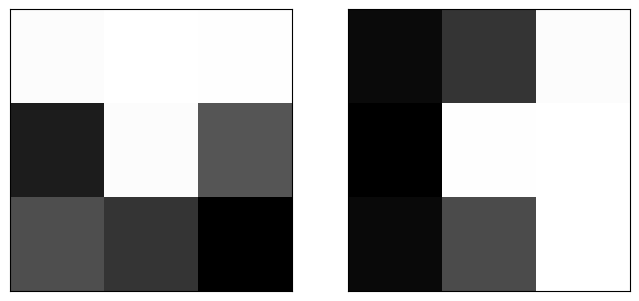

In [281]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

for i, ax in enumerate(axes):
    ax.imshow(ng.synaptic_weights[i], cmap='gray')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)

In [286]:
ng.reset_metric()

In [287]:
correct = 0
train_iters = 40000
# 进行训练
for i in range(train_iters):
    random_number = random.random()
    if random_number > 0.5:
        pred = ng.process(A.spikes, label=1, train=True)
        correct += int(pred == 1)
    else:
        pred = ng.process(B.spikes, label=0, train=True)
        correct += int(pred == 0)
print(f"Accuracy: {correct / train_iters}")

Accuracy: 0.877075


In [288]:
# Test
correct = 0
n_iters = 200
for i in range(n_iters):
    rand_number = random.random()
    if rand_number > 0.5 :
        #print("\nProcessing 0")
        pred = ng.predict(A.spikes)
        correct += int(pred == 1) 
        logging.info('-'*20 + f'Predicted {pred}, real {0}')
    else:
        #print("\nProcessing 1")
        pred = ng.predict(B.spikes)
        correct += int(pred == 0) 
        logging.info('-'*20 + f'Predicted {pred}, real {1}')

print(f'Accuracy: {correct/(n_iters)}')

Accuracy: 1.0


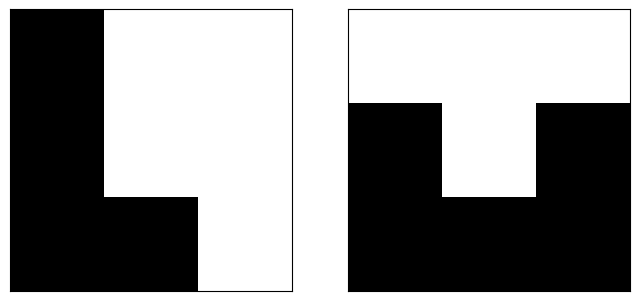

In [289]:
fig, axes = plt.subplots(1, len(ng.synaptic_weights), figsize=(8, 5))

for i, ax in enumerate(axes):
    ax.imshow(ng.synaptic_weights[i], cmap='gray')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)

###### 这里的RSTDP的grid的设计就很自然的规避掉了，对一个分类的修改，进而产生对另一个的影响，这里相当于做了两套系统
    + 只要有（脉冲）奖励、惩罚信号产生，剩下的更新过程都是在，那个脉冲对应的权重w上进行修改----这里很关键
        + 如果有脉冲输出-也就是有奖励或惩罚，那么就把第一个脉冲所在w拿出来，进行下面的迭代，但是有个问题就是，
            + 奖励-就强化分类正确的stdp
            + 惩罚-就反向强化所有stdp
        + 没有脉冲输出
            + 就微强化正向权重
      

+ grid 的引入相当于两套系统-回避掉了互相掣肘的问题
+ grid 的引入，也就存在grid遍历有先后顺序，总给我的感觉是有问题的，但好像又没问题